# Finding discords of any length in a time series

This tutorial explains the MERLIN3 (hereafter referred to as fastMERLIN) algorithm. This algorithm is a faster version of MERLIN algorithm, which is initially proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). A MATLAB implementation of fastMERLIN algorithm can be found on the support webpage here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm discovers the discords of arbitrary length in time series.

## import libraries

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import copy

plt.style.use('stumpy.mplstyle')

## import toy data set: noisy sine wave

In [2]:
from scipy.io import loadmat

# data set is available at: 
# https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

## Visualizing data

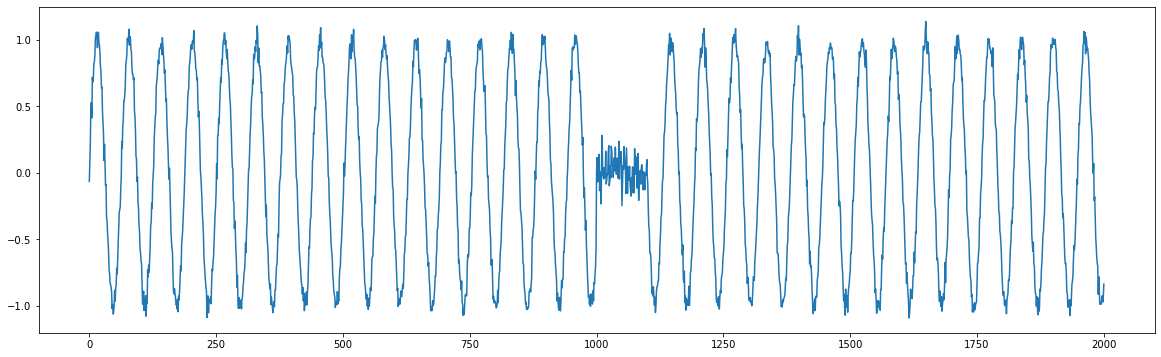

In [3]:
plt.plot(ts)
plt.show()

As depicted in the figure above, there is an anomaly in the sequence. In the following, the fastMERLIN algorithm is implemented and used to discover this anomaly.

## implemeting fastMERLIN algorithm

According to the implementation of fastMERLIN on the support wenbage, this algorithm is not modularized. To make the code clean, we break the algorithm to several parts and they are named by the authors of the python code.

**NOTE:** This algorithm analyze the subsequences block by block. This is to use the power of vectorization. The size of block can be set by the user. The author of MERLIN3 stated that 256 sounds to be good.

### Phase I: FAST SEARCH algorithm 

In the first part of the fastMERLIN algorithm, all the subsequences within a block (i.e. the starting index is in the block) is being compared with each other. Also, the so-far-selected candidates (i.e. the ones that are discovered prior to a block) are being compared to all the subsequences of the current block.

In [4]:
#preprocessing time series: z-normalizing all subsequences and store them in the memory
def get_all_subsequences(T, m):
    """
    Parameters
    ----------
    T: ndarray
    the time series in which we are looking for the discord
    L: scalar
    the length of discord
    
    output
    ---------
    subsequences: a n-by-L matrix where n is the number of subsquences of length L in T
    
    NOTE:
    It is faster to extract all subsquences first in the beginning of the algorithm
    """    
    n_T = T.shape[0]
    if not (4 <= m <= n_T//2):
        raise ValueError("the  length of L must be in the range of 4 <= L <= floor(len(T)/2)")
    
    #calculate n: the number of subsequence of length m in T
    n = n_T - m + 1 
    
    subsequences = np.zeros((n, m))
    for i in range(n):
        subsequences[i, :] = T[i: i + m]
    subsequences = stumpy.core.z_norm(subsequences, axis=1) #z-normalizing each subsequence
    
    return subsequences

In [5]:
#phase 1 of fastMERLIN
def fast_search(subsequences, min_dist, excl_zone=None, max_block_size=256):
    """
    For a time series T, this function finds discord candidates by rejecting 
    the ones whose distance to some of their neighbors are less than min_dist.
    
    Parameters
    ------
    subsequences: ndarray 
    subsequences[i,:] contains the subsequence of the main time series, and "i" is its starting index. 
    
    min_dist: scalar
    the lowest distance that a discord should have with its Nearest Neighbor
    
    excl_zone: scalar
    the minimum seperation between a discord of length m, and its nearest neighbor
    (it defines the exclusion zone as [i-excl_zone+1, i+excl_zone])
    
    max_block_size: scalar
    the maximum size of each block  
    
    output:
    -------
    cand_index: 1darray that contains the starting index of the discord candidates in ascending order
    """
    #get the total number of subsequences (n) and the length of discord (m) 
    n, m = subsequences.shape 
    
    if not (0 < min_dist <= 2 * np.sqrt(m)): 
        raise ValueError("A valid choice of min_dist must be greater than 0 and less than or equal to 2*sqrt(m)")
    #convert z-normalized euclidean distance "min_dist" to "r"
    #r: the max value of dot product allowed for a discord and its  nearest  neighbor
    r = m * (1 - ((min_dist ** 2)  / (2 * m)))
    
    if excl_zone is None:
        excl_zone = math.ceil(m / 4) #the default setting for STUMPY
    
    counter = 0 #counts the number of candidates discovered.
    cand = np.zeros((n, m)) #contains the subsequences that are selected as candidates (e.g. cand[0,:] is the first  candidate)
    cand_index = np.zeros(n, dtype='int') #contains the starting index of the candidates in ascending order
    
    #NOTE:
    #We modify cand and cand_index such that the first "counter" elements are the candidates 
    #So, we don't care about any element of cand / cand_index with index >= counter
    #According to the author of MATLAB code, this approach is faster than changing the size of cand and cand_index,  
    #OR even removing the elements that are located at index >= "counter"
    
    #iterating through the blocks 
    for i in range(0, n, max_block_size):
        block_size = min(max_block_size, n - i) #to consider the size of last block!
        is_cand_in_block = np.full(block_size, True) #at first, we assume all subsequences in the block can be a candidate.
        
        #STEP(1): compare all the so-far-discovered candidates(i.e. the ones from previous blocks)...
        #to all subsequences of currnt block 
        #Further Explanation: for any subsequence, its neighbors might be located later or earlier in the time series T...
        #In this phase, we are trying to scan the neighbors that come after the subsequence. 
        #That is why we compare ALL subsequences of a block with the so-far-discovered candidates that located before the block
        #In the next phase (i.e. phase 2), the neighbors that come before the subsequence is being considered.
        if counter > 0: #i.e. we have some candidates discovered from previous blocks!
            is_cand_so_far = np.full(counter, True)
            if cand_index[0] <= i + block_size - excl_zone - 1: 
                #last_cmp: the last candidate that can be considered with (some of) subsequences in the current block
                last_cmp = np.where(cand_index[:counter] <= i + block_size - excl_zone -1)[0][-1]
                
                #determining last_no_conflict: the last candidate that has no conflict with the block!
                #Explanation: determining this can help us use the vectorization on all subsequences of the block
                if cand_index[0] > i - excl_zone:
                    last_no_conflict = -1
                else:
                    last_no_conflict = np.where(cand_index[0] <= i - excl_zone)[0][-1]
                
                    corr = np.matmul(cand[:(last_no_conflict + 1), :], subsequences[i : (i + block_size), :].T)
                    mask = (corr > r) 
                    is_cand_in_block[np.any(mask, axis=0)] = False
                    is_cand_so_far[np.ix_(np.any(mask, axis=1))[0]] = False
                
                #now, we should compare the rest of discords, located after last_no_conflict but not beyond last_cmp
                for pos in range(last_no_conflict + 1, last_cmp + 1):
                    first_cmp = max(i, cand_index[pos] + excl_zone)
                    corr = np.matmul(cand[pos,:], subsequences[first_cmp: i + block_size, :].T)
                    mask = (corr > r)
                    if np.any(mask):
                        is_cand_so_far[pos] = False
                        index_reset = np.where(mask)[0] + first_cmp - i
                        is_cand_in_block[index_reset] = False
                
            
            #update counter according to the current vector "is_cand_so_far" as some of them have been rejected recently
            #NOTE: we should also update counter according to "is_cand_in_block" as we might found some new candidates inside the block. 
            #This is performed after the within-block comparision. 
            #within-block comparision as well. 
            surviving_counter = np.sum(is_cand_so_far)
            if surviving_counter < counter: 
                counter = surviving_counter
                tmp_loc = np.where(is_cand_so_far)[0]
                cand_index[:counter] = cand_index[tmp_loc]
                cand[:counter, :] = cand[tmp_loc, :]
        #########################################################################
        #STEP(2): within-block comparison
        if block_size > excl_zone: #i.e. we are allowed to do within-block comparison
            for pos in range(excl_zone, block_size):
                #although dot product is not correlation, name "corr" sounds appropriate to show we are using corr concept.
                corr = np.matmul(subsequences[i + pos,:], subsequences[i:i + pos - excl_zone + 1 ,:].T) 
                mask = (corr > r)
                if np.any(mask):
                    is_cand_in_block[pos] = False
                    is_cand_in_block[np.where(mask)[0]] = False
        
        #NOTE: 
        #It is important to note that we should also... 
        #compare "the discovered candidates of current block" with "ALL subsequences in the previous blocks!!!" 
        #This will be done in the second phase!!! 
        ##########################################################################
        #STEP(3): update counter according to "is_cand_in_block"
        cand_actual_idx = np.where(is_cand_in_block)[0] + i
        if len(cand_actual_idx)>0:
            prev_counter = counter
            counter = counter + len(cand_actual_idx)
            cand[prev_counter : counter,:] = subsequences[cand_actual_idx]
            cand_index[prev_counter : counter] = cand_actual_idx
    
    return cand_index[:counter]       

In [6]:
#Input
T = ts[:]
m = 512 #one day as the length of subsequence
min_dist = 10.27
max_block_size=256

subsequences = get_all_subsequences(T, m)
cand_index = fast_search(subsequences, min_dist, )
cand_index

array([ 584,  585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
        595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  613,
        614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,
        625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  646,
        647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  677,  678,  679,
        680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,
        691,  692,  693,  694,  695,  696,  710,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  749,  750,  751,  780,  781,
        906,  907,  908, 1386, 1387, 1388, 1393, 1394, 1395, 1396, 1400,
       1401, 1402, 1403, 1404, 1405, 1406, 1407])

### Phase II: FAST PRUNE algorithm

In the second phase of fastMERLIN, each candidate will be compared with ALL subsequences that are preceding it. In other words, ALL subsequences of a block will be compared with all candidates that are succeeding it! 

**NOTE:** Although we did some pruning in the phase I, we decided to name this stage the "fast pruning" phase as it only prunes the discovered candidates.

In [7]:
def fast_prune(subsequences, min_dist, excl_zone, max_block_size, cand_index):
    """
    For a time series T, this function finds discord candidates by rejecting 
    the ones whose distance to some of their neighbors are less than min_dist.
    
    Parameters
    ------
    subsequences: ndarray 
    subsequences[i,:] contains the subsequence of the main time series, and "i" is its starting index. 
    
    min_dist: scalar
    the lowest distance that a discord should have with its Nearest Neighbor
    
    excl_zone: scalar
    the minimum seperation between a discord of length m, and its nearest neighbor
    (it defines the exclusion zone as [i-excl_zone+1, i+excl_zone])
    
    max_block_size: scalar
    the maximum size of each block  
    
    cand_index: ndarray
    contains the starting index of discord candidates (discovered from phase I)
    
    output:
    -------
    cand_index: 1darray that contains the starting index of the discord candidates in ascending order
    """
    counter = cand_index.shape[0]
    cand = subsequences[cand_index, :]
    
    n, m = subsequences.shape
    r = m * (1 - ((min_dist ** 2)  / (2 * m)))
    
    for i in range(0, n, max_block_size):    
        if counter == 0: #i.e. no candidate is discovered from previous phase!
            break
        
        is_cand_so_far = np.full(counter, True)
        block_size = min(max_block_size, n - i)
        
        min_index = max(i + block_size, i + excl_zone)
        
        if cand_index[counter-1] < min_index: #i.e. no candidates after this block (so, we are done!!!)
            break 
        
        first_cmp = np.where(cand_index[:counter] >= min_index)[0][0] #to find the very first candidate after the block
        no_conflict_begin = i + block_size + excl_zone - 1 #to find the lowest index after the block that has no conflict with it 
        
        if cand_index[counter-1] < no_conflict_begin:  #i.e. All discords after the block has conflict with it.
            first_no_conflict = counter  
        else:
            #to find the candidates (of after the block) that have no conflict with the block!
            first_no_conflict = np.where(cand_index[first_cmp:counter] >= no_conflict_begin)[0][0] + first_cmp 
        
        for pos in range(first_cmp, first_no_conflict):
            corr = np.matmul(cand[pos,:], subsequences[i : cand_index[pos] - excl_zone + 1, :].T)
            if np.any(corr > r):
                is_cand_so_far[pos] = False
        
        if first_no_conflict < counter:
            corr = np.matmul(cand[first_no_conflict: counter, :], subsequences[i: i + block_size ,:].T)
            mask = (corr > r)
            index_reset = np.where(np.any(mask, axis=1))[0] + first_no_conflict
            is_cand_so_far[index_reset] = False
        
        #update counter, cand, and cand_index:
        surviving_counter = np.sum(is_cand_so_far)
        if  surviving_counter < counter:
            counter = surviving_counter
            still_cand_idx = np.where(is_cand_so_far)[0]
            cand_index[:counter] = cand_index[still_cand_idx]
            cand[:counter, :] = cand[still_cand_idx, :]
    
    return cand_index[:counter]

In [8]:
cand_index = fast_prune(subsequences, min_dist, 
                        excl_zone=math.ceil(m/4),
                        max_block_size=max_block_size, 
                        cand_index=cand_index)
cand_index

array([592, 593, 594, 621, 622, 623, 624, 625, 626, 627, 652, 653, 654,
       655, 656, 657, 658, 659, 683, 684, 685, 686, 687, 688, 689, 690,
       691, 715, 716, 717, 718, 719, 720, 749, 750, 751, 780, 781, 906,
       907, 908])

As observed, the number of candidates have been reduced after the pruning process.

So far, we have discovered the candidates for the discord and we know that the discord is among them. Now, we can start searching for their nearest neighbor and stores the distance to NN and the index of NN. 

# Phase III: find NearestNeighbor

In [9]:
def find_NearestNeighbor(subsequences, min_dist, excl_zone, max_block_size, cand_index):
    """
    For a time series T, this function finds the dist-to-NearestNeighbor and the NearestNeighbor index of the candidartes whose index stored in cand_index.
    
    Parameters
    ------
    subsequences: ndarray 
    subsequences[i,:] contains the subsequence of the main time series, and "i" is its starting index. 
    
    min_dist: scalar
    the lowest distance that a discord should have with its Nearest Neighbor
    
    excl_zone: scalar
    the minimum seperation between a discord of length m, and its nearest neighbor
    (it defines the exclusion zone as [i-excl_zone+1, i+excl_zone])
    
    max_block_size: scalar
    the maximum size of each block  
    
    cand_index: ndarray
    contains the starting index of selected subsequences
    
    output:
    -------
    discord_idx: the same as cand_index
    discord_nn_idx: 1darray that contains the starting index of the candidates' nearest neighbor
    discord_dist: 1darray that contains the distance of each subsequence in discord_index to its nearest neighbor
    """
    #discord_idx is the same as cand_index. We are not trying to prune the candidates in this phase. 
    #Instead, we find the nearest neighbor(NN) of each candidate and then... 
    #choose the the discord later by finding the candidate that has highest dist to its NN.
    discord_idx = cand_index 
    n_cands = len(cand_index)
    ############################################################################################
    #Initializing the other outputs of this function
    discord_nn_idx = -1 * np.ones(n_cands, dtype='int')
    discord_dist = -1 * np.ones(n_cands)
    
    cand = subsequences[cand_index, :]
    n, m = subsequences.shape
    r = m * (1 - ((min_dist ** 2)  / (2 * m)))
    
    if n_cands: #i.e. at least one candidate is discovered!
        for i in range(0, n, max_block_size):
            block_size = min(max_block_size, n - i)
            
            #to see what discords can have conflict with the subsequences of block
            mask = (cand_index >= i - excl_zone + 1) & (cand_index < i + block_size + excl_zone -1) 
            if np.any(mask):
                with_conflicts = np.where(mask)[0]
                first_conflict = with_conflicts[0]
                last_conflict = with_conflicts[-1]
            else:
                first_conflict = n_cands
                last_conflict = []
                
            if first_conflict >= 1: 
                #so there are some discords (before first_conflict) that don't have conflict with block. 
                #The following block considers this case.
                corr = np.matmul(cand[:first_conflict, :], subsequences[i:i + block_size, :].T)
                max_corr_NN_idx = np.argmax(corr, axis=1) #NN means min distance, which is equivalent to largest correlation
                max_corr = corr[np.arange(corr.shape[0]), max_corr_NN_idx] #instead of doing np.max(corr, axis=1)

                update = np.where(max_corr > discord_dist[:first_conflict])[0]
                discord_nn_idx[update] = max_corr_NN_idx[update] + i
                discord_dist[update] = max_corr[update]
    
            if first_conflict < n_cands:
                #Now, we reach the candidates that have conflicts with the block. 
                #The following covers the candidates up to cand_index[last_conflict] 
                for pos in range(first_conflict, last_conflict + 1):
                    #conflicting with ONLy the beginning of the block  
                    if abs(cand_index[pos] - i) < excl_zone:
                        #now, we only consider cases where the subsequence has conflict with the beginning. 
                        #NOTE: it is possible that these subsequences have conflict with end of the block as well. However,
                        #we don't consider them here. (This will be considered seperately)
                        if abs(cand_index[pos] - (i + block_size - 1) ) >= excl_zone : 
                            #find the index onwards which the subsequences have no conflict with cand_index[pos]
                            cmp_begin = cand_index[pos] + excl_zone 
                        
                            corr = np.matmul(cand[pos,:], subsequences[cmp_begin : i + block_size, :].T)
                            max_corr_NN_idx = np.argmax(corr)
                            max_corr = corr[max_corr_NN_idx]
                            if max_corr > discord_dist[pos]:
                                discord_nn_idx[pos] = max_corr_NN_idx + cmp_begin
                                discord_dist[pos] = max_corr

                    #conflicting with the end of the block 
                    #NOTE: here we lose the chronological order between subsequences as we seach through the ones that have conflict...
                    #with end of the block before investigating the ones that are completely inside the block!
                    #Therefore, the NN index of a discord might not be the same as what can be achieved by STUMPY MatrixProfile
                    elif abs(cand_index[pos] - (i + block_size - 1) ) <= excl_zone:
                        corr = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - excl_zone + 1), :].T) 
                        max_corr_NN_idx = np.argmax(corr)
                        max_corr = corr[max_corr_NN_idx]
                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_NN_idx + i
                            discord_dist[pos] = max_corr

                    #no conflict with the two ends of block (it is inside the block!)
                    else:
                        corr_left = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - excl_zone + 1), :].T)
                        corr_right = np.matmul(cand[pos,:], subsequences[(cand_index[pos] + excl_zone) : i + block_size, :].T)
                        
                        max_corr_leftNN_idx = np.argmax(corr_left)
                        max_corr_rightNN_idx = np.argmax(corr_right)
                        
                        max_corr_left = corr_left[max_corr_leftNN_idx]
                        max_corr_right = corr_right[max_corr_rightNN_idx]
                        
                        if max_corr_left > max_corr_right:
                            max_corr = max_corr_left
                            max_corr_NN_idx = max_corr_leftNN_idx + i
                        else:
                            max_corr = max_corr_right
                            max_corr_NN_idx = max_corr_rightNN_idx + cand_index[pos] + excl_zone

                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_NN_idx
                            discord_dist[pos] = max_corr
                    
                    
                    
                if last_conflict < n_cands - 1:
                    #i.e. there some discords after the block that
                    #do not have conflict with it
                    corr = np.matmul(cand[last_conflict + 1:, :], subsequences[i: i + block_size].T)
                    max_corr_NN_idx = np.argmax(corr, axis=1)
                    max_corr = corr[np.arange(corr.shape[0]), max_corr_NN_idx]

                    update = np.where(max_corr > discord_dist[last_conflict + 1:])[0]
                    discord_nn_idx[update + last_conflict + 1] = max_corr_NN_idx[update] + i
                    discord_dist[update + last_conflict + 1] = max_corr[update]        

    
    z_euclidean_dist = 2 * m * (1 - discord_dist / m)
    discord_dist = np.sqrt(np.where(z_euclidean_dist>0, z_euclidean_dist, 0)) #to take care of numerical error.

    return discord_idx, discord_nn_idx, discord_dist

In [10]:
discord_idx, discord_nn_idx, discord_dist = find_NearestNeighbor(subsequences, min_dist, 
                        excl_zone=math.ceil(m/4),
                        max_block_size=max_block_size, 
                        cand_index=cand_index)


df = pd.DataFrame()
df['discord_idx'] = discord_idx
df['discord_nn_idx'] = discord_nn_idx
df['discord_dist'] = discord_dist

df = df.sort_values(by='discord_dist', ascending=False)
df

,discord_idx,discord_nn_idx,discord_dist
30,718,278,10.301397
31,719,1096,10.301242
22,687,247,10.297374
21,686,246,10.297224
23,688,248,10.295380
29,717,277,10.295350
13,655,215,10.294041
14,656,216,10.291022
12,654,214,10.290871
20,685,245,10.289942


#### PLOT the Top Discord

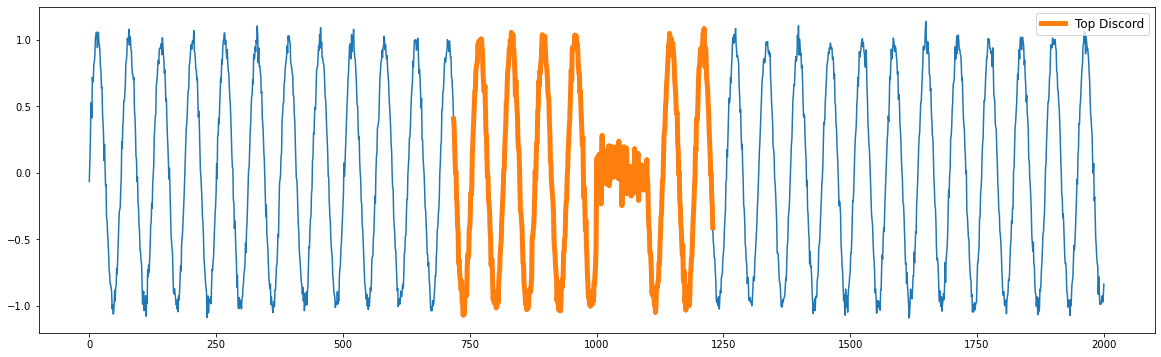

In [9]:
Top_Discord = discords_sorted.iloc[0,:]
Top_Discord_idx = int(Top_Discord[0])

plt.plot(ts)
plt.plot(np.arange(Top_Discord_idx,Top_Discord_idx+m),ts[Top_Discord_idx:Top_Discord_idx+m], lw=5, label='Top Discord')
plt.legend(fontsize=12)
plt.show()

In [10]:
#reproduce result of paper
discords_idx_sorted = discords.sort_values(by ='Discord index', ascending=True)
discords_idx_sorted

,Discord index,Discord NN index,NN distance
0,592.0,152.0,10.270556
1,593.0,153.0,10.274022
2,594.0,154.0,10.273065
3,621.0,181.0,10.270276
4,622.0,182.0,10.278849
5,623.0,183.0,10.284921
6,624.0,184.0,10.285366
7,625.0,185.0,10.285081
8,626.0,186.0,10.279453
9,627.0,187.0,10.272296


### DRAG algorithm:

Let's combine the first two algorithm to only return the first discorc

In [11]:
def DRAG(T,m,r, separation_fraction=None):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    idx: index of top discord
    idx_NN: index of NN of top discord
    dist: dist between top discor and its NN  
    """
    
    #initializing output
    idx = -1; idx_NN = -1; dist = -1
    
    if separation_fraction is None:
        separation_fraction = 1/4
    
    sep = math.ceil(m*separation_fraction) + 1
    
    C = candidate_selection_algorithm(T, m, r, sep) 
    
    if len(C)>0:
        discords = discords_refinement_algorithm(T, m, r, C, sep)
        
        if len(discords['NN distance'])>0:
            top_discord = discords['NN distance'].argmax()
            idx = int(discords.iloc[top_discord, 0])
            idx_NN = int(discords.iloc[top_discord, 1])
            dist = discords.iloc[top_discord, 2] 

    return idx, idx_NN, dist

In [12]:
TopDiscord_idx, TopDiscord_idx_NN, TopDiscord_dist = DRAG(T,m,r) 

print("TopDiscord_idx: ", TopDiscord_idx)
print("TopDiscord_idx_NN: ", TopDiscord_idx_NN)
print("TopDiscord_dist: ", TopDiscord_dist)

TopDiscord_idx:  718
TopDiscord_idx_NN:  278
TopDiscord_dist:  10.301397123539063


In [13]:
#let's use STUMPY matrix profile:
mp = stumpy.stump(T, m)
discord_idx_MP = np.argmax(mp[:,0])
discord_NN_idx_MP = mp[discord_idx_MP,1]
discord_dist_MP = mp[discord_idx_MP,0]

print("discord_idx via matix profile: ", discord_idx_MP)
print("discord_NN_idx via matix profile: ", discord_NN_idx_MP)
print("discord_dist via matix profile: ", discord_dist_MP)

discord_idx via matix profile:  718
discord_NN_idx via matix profile:  278
discord_dist via matix profile:  10.30139712353895


### part II: MERLIN algorithm 

After the implementation of DRAG algorithm, we are at the position where we can start to implement MERLIN algorithm:

In [14]:
def MERLIN(T, MinL, MaxL, separation_fraction=None):
    """
    For a time series T, the algorithm finds discords with length between MinL and MaxL. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    MinL: int
        subsequence length lower bound
    
    MaxL: int
        subsequence length upper bound
    
    separation_fraction: to exclude indices; If None, set it to 1/4 of subsequence length 
    
    output
    --------
    Discords : ndarray
        a two dimentional array where the axis 0 contains different discords and axis 1 has the information 
        of discord: 
        first column is the starting index of the discord subsequence
        second column is the length of the discord
        third column is the NN index
        fourth column is the distance of the discord to its NN
    
    """
    Discords = np.empty(shape = (0, 4), dtype='object') #Alternatively: Create np array with nrows=MaxL-MinL+1
    
    
    # Calculate the first discord of length MinL
    print('Stage#1: Calculating the first discord...')
    m = MinL
    r = 2 * (m ** 0.5)
    dist = -1
    while dist < 0:
        idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
        r = r / 2
    
    new_discord = [idx, m, idx_NN, dist]
    Discords = np.vstack((Discords, new_discord))
    print('Discords after finding the first one: \n', new_discord)
    
    
    # Calculate next four discords (for the next four subsequent length)
    print('Stage#2: Calculating the next four discords...')
    dist_old = dist # we need the dist of the previous discord to modify r
    for m in range(MinL+1,MinL+5): 
        r = 0.99 * dist_old 
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
            r = 0.99 * r
            
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        dist_old = dist
        print('>>> Discords after finding the next four discords: ', new_discord)
    
    
    # Calculate the remaining discords
    print('Stage#3: Calculating the remaining discords...')
    for m in range(MinL+5,MaxL+1): #what if MinL+5 > MaxL+1 ? (we need to consider such scenarios)
        mu_dist = np.mean(Discords[-5:, 3]) # calculating the mean of distance of the last 5 discovered discords 
        std_dist = np.std(Discords[-5:, 3]) # calculating the std of distance of the last 5 discovered discords
        
        r = mu_dist - 2 * std_dist
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
            r = r - std_dist
        
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        print('>>> new discord: ', new_discord)
    
    
    return Discords

## Let's use MERLIN on TAXI data (Fig. 11)

In [15]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']
data

,value
timestamp,
2014-10-01 00:00:00,12751
2014-10-01 00:30:00,8767
2014-10-01 01:00:00,7005
2014-10-01 01:30:00,5257
2014-10-01 02:00:00,4189
...,...
2014-12-15 21:00:00,21393
2014-12-15 21:30:00,21577
2014-12-15 22:00:00,21019


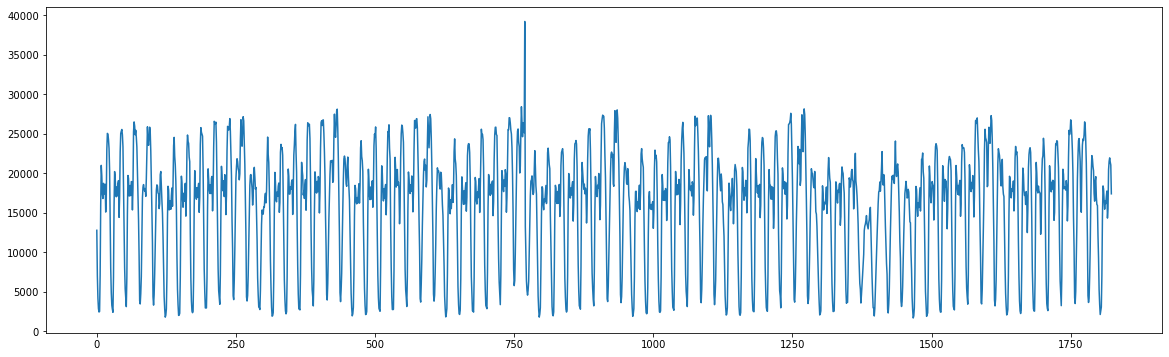

In [16]:
ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [67]:
np.set_printoptions(suppress=True)
Discords = MERLIN(ts, 5, 96)

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [1690, 5, 1120, 1.3642079150627304]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [1522, 6, 1100, 1.4064712539239808]
>>> Discords after finding the next four discords:  [537, 7, 1689, 1.62928107746437]
>>> Discords after finding the next four discords:  [1380, 8, 443, 1.746810126819628]
>>> Discords after finding the next four discords:  [762, 9, 1328, 2.0634858945465493]
Stage#3: Calculating the remaining discords...
>>> new discord:  [761, 10, 1327, 2.1247537919540944]
>>> new discord:  [760, 11, 1381, 2.629462897528745]
>>> new discord:  [759, 12, 1380, 2.746225055671875]
>>> new discord:  [758, 13, 1379, 2.9819137944892202]
>>> new discord:  [757, 14, 1261, 3.5977491081910626]
>>> new discord:  [756, 15, 1260, 3.7262163688495025]
>>> new discord:  [755, 16, 1259, 3.8542112273477858]
>>> new discord:  [754, 17, 1258, 3.773480491623614]
>>> new disco

In [68]:
#printing Discords:
Discords

array([[1690.0, 5.0, 1120.0, 1.3642079150627304],
       [1522.0, 6.0, 1100.0, 1.4064712539239808],
       [537.0, 7.0, 1689.0, 1.62928107746437],
       [1380.0, 8.0, 443.0, 1.746810126819628],
       [762.0, 9.0, 1328.0, 2.0634858945465493],
       [761.0, 10.0, 1327.0, 2.1247537919540944],
       [760.0, 11.0, 1381.0, 2.629462897528745],
       [759.0, 12.0, 1380.0, 2.746225055671875],
       [758.0, 13.0, 1379.0, 2.9819137944892202],
       [757.0, 14.0, 1261.0, 3.5977491081910626],
       [756.0, 15.0, 1260.0, 3.7262163688495025],
       [755.0, 16.0, 1259.0, 3.8542112273477858],
       [754.0, 17.0, 1258.0, 3.773480491623614],
       [753.0, 18.0, 1257.0, 3.4080630531206326],
       [753.0, 19.0, 1593.0, 3.173663379789231],
       [752.0, 20.0, 1592.0, 2.8985780733789492],
       [752.0, 21.0, 1592.0, 2.670509417879137],
       [769.0, 22.0, 97.0, 2.513778263195744],
       [769.0, 23.0, 97.0, 2.566742363683388],
       [769.0, 24.0, 97.0, 2.5845448370266633],
       [768.0, 25.0

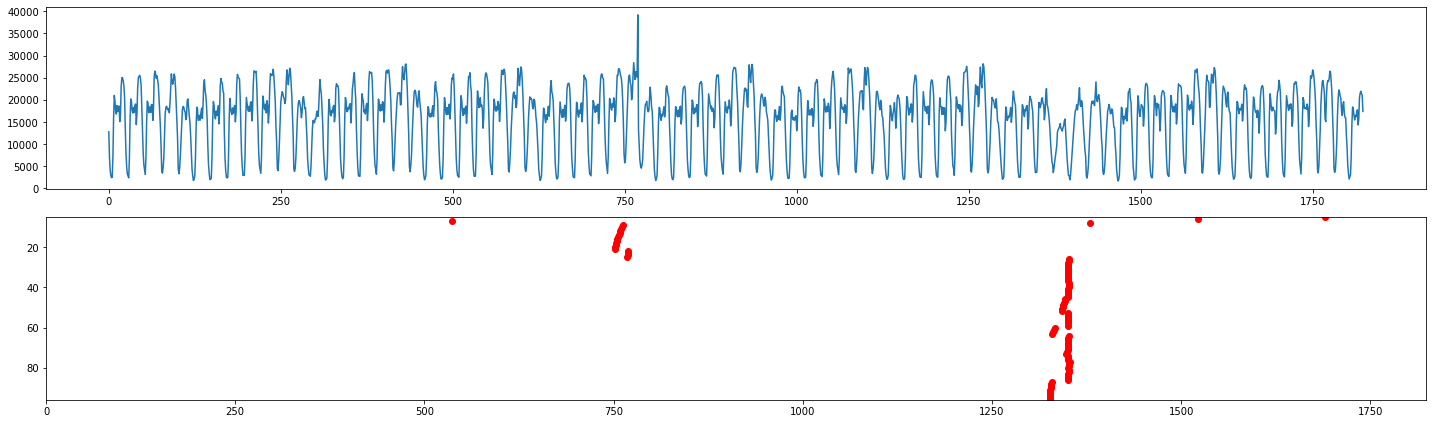

In [69]:
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

There are a few discords that is not "clearly" illustrated in the figure 11 of the paper. However, if we zoom in, we will notice that these points are shown (but with lower color value.) These points might be false positives as discussed by paper in some sections.

### Comparing with MATLAB (by the author)

The figure obtained by MATLAB code shown below. Some points are highlighted. These are the ones that are vaguely illustrated in Fig. 11.

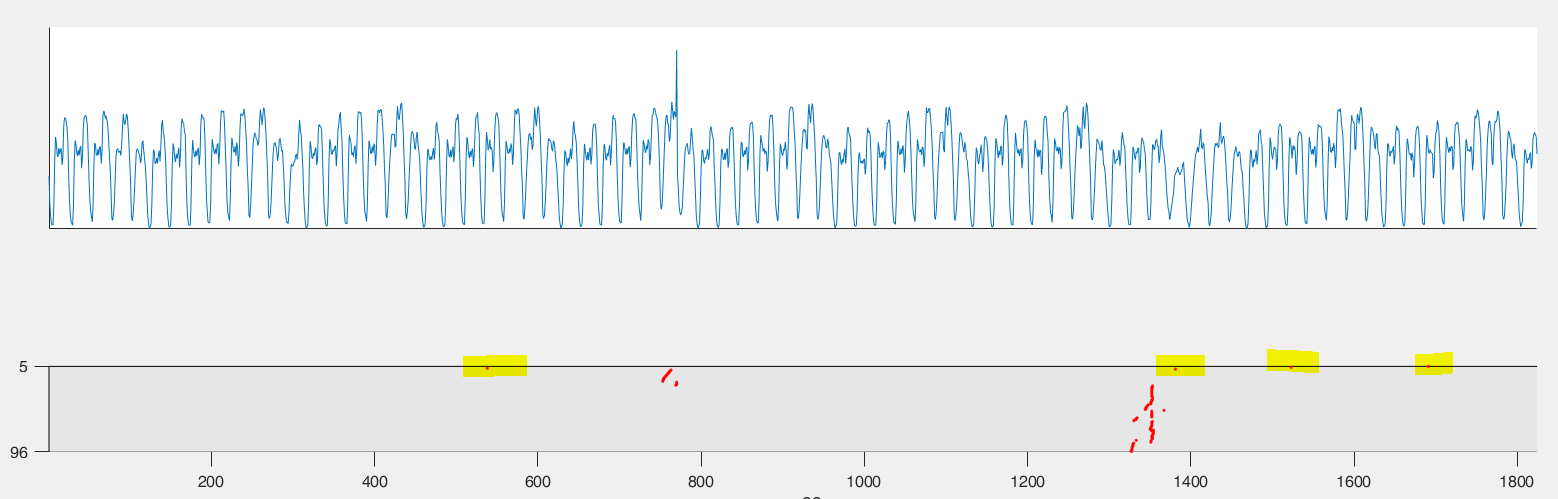



### Comparing values obainted by Python / MATLAB

In [70]:
#two files: Taxi_MATLAB_results.csv (MERLIN3), Taxi_MATLAB_results_r99percent.csv (MERLIN3 but with r=r*0.99)
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\taxi_results_by_MATLAB\\Taxi_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = np.abs(Discords_MATLAB - Discords_Python)
    print(f'> differece at col={col} is: \n {diff}')

> differece at col=0 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 24.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.0 0.0 3.0 2.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=1 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=2 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 

### plot discords that are different in MATLAB and Python

mask:  [47 68 70 71 79]
> Discords_by_MATLAB_only: 
 [[1367.           52.          286.            3.68959178]
 [1354.           73.          969.            5.44054626]
 [1354.           75.           10.            5.5274995 ]
 [1354.           76.           10.            5.5868335 ]
 [1333.           84.          948.            5.55797485]]
>  Discords_by_Python_only: 
 [[1342.0 52.0 240.0 4.290034033714779]
 [1348.0 73.0 963.0 5.351572212173198]
 [1350.0 75.0 1301.0 5.411437945118361]
 [1351.0 76.0 1302.0 5.497467824497779]
 [1351.0 84.0 1519.0 5.963234981527579]]
n_discord:  5


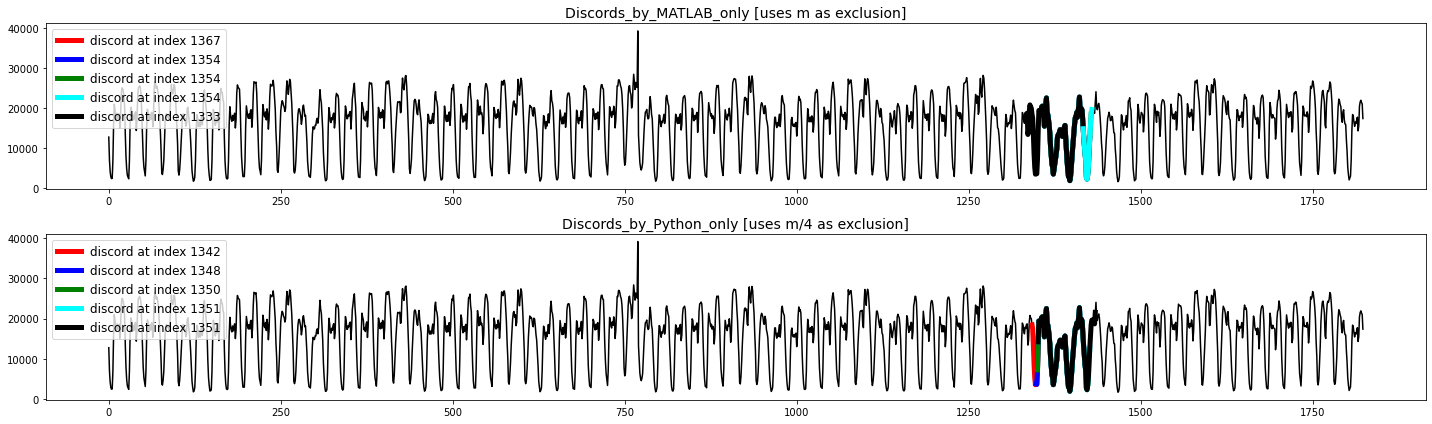

In [74]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

print('=======================================================================')

#plotting
n_discord = len(Discords_by_Python_only) #= len(Discords_by_MATLAB_only) = len(Discords_by_Python_only)
print('n_discord: ', n_discord)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts, 'k')
ax[1].plot(ts , 'k')

color_vec = ['r','b','g','cyan', 'k']
for n in range(n_discord):
    idx = int(Discords_by_MATLAB_only[n][0])               
    m = int(Discords_by_MATLAB_only[n][1])
    ax[0].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")
    
    idx = int(Discords_by_Python_only[n][0])
    m = int(Discords_by_Python_only[n][1])
    ax[1].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")


ax[0].set_title("Discords_by_MATLAB_only [uses m as exclusion]",fontsize=14)
ax[1].set_title("Discords_by_Python_only [uses m/4 as exclusion]",fontsize=14)

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

fig.tight_layout()
plt.show()

## Let's use MERLIN on Mars Science Laboratory data (Fig. 17)

### Fig 17 (Top)

In [ ]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\A-4.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 100; MaxL = 200;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

In [ ]:
#let's compare it with MATLAB:
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\MSL_A_4_results_by_MATLAB\\MSL_A_4_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = Discords_MATLAB - Discords_Python
    print(f'> differece at col={col}: \n {diff}')
    print('------------------------------------')

In [ ]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

### Fig 17 (Bottom)

In [ ]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.figure(figsize=(20,2))
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 50; MaxL = 500;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

# Implementing fastMERLIN (provided in the supporting page of the paper)

In [72]:
def fastMERLIN(T, minL, maxL, min_dist=None, min_sep_fraction = None, max_block_size=256, MERLIN_initializer=True):
    """
    Input:
    -------
    T: a 1d-array
    minL: discord's minimum length
    maxL: discord's maximum length
    min_dist: minimum "z-normalized euclidean distance" a discord should must have with its nearest neighbor
    If None, it is set to 2*sqrt(minL+1)
    min_sep_fraction: sets the exclusion zone width (from center) as sep = math.ceil(min_sep_fraction*min_sep_fraction). 
    So, the exclusion zone for i-th subsequence becomes [i-sep+1, i + sep -1]. If None, it is set
    to 1/4. It can take any value in (0,1]
    max_block_size: the block size based on which the algorithm find the candidates 
    

    Output:
    -------
    NOTE: num_L = maxL - minL + 1
    
    discord_indices: a 1d array of size num_L that stores the indices of all discovered discords
    discord_NN_indices: a 1d array of size num_L that stores the indices of discovered
    discords's nearest neighbors
    discord_dist: a 1d array of size num_L that stores the distance between each discord and
    its nearest neighbors
    discord_times: a 1d array of size num_L that stores the computation time spent for finding discords in seconds
    discord_misses: a 1d array of size num_L that stores the number of times that we had to reduce min_dist to
    allow algorithm find a discord
    """
    if min_dist is None:
        min_dist = 2 * np.sqrt(minL+1) #changed to minL+1 to consider stumpy's z-normalization
    
    #set min_sep if it is not set by the user
    if min_sep_fraction is None:
        min_sep_fraction = 1/4
    
    L_values = np.arange(minL, maxL+1)
    n_discords = len(L_values) #number of discords that will be discovered

    discord_indices = np.empty(n_discords, dtype='int')
    discord_NN_indices = np.empty(n_discords, dtype='int')
    discord_dists = np.empty(n_discords)

    discord_times = np.zeros(n_discords)
    discord_misses = np.zeros(n_discords, dtype='int')

    for i, L in enumerate(L_values):
        #print('---')
        print(f'L: {L}', end='>>>')
        tic = time.time()
        while True:
            #print(f'.....ATTEMPT: #{discord_misses[i]}: USING min_dist: {min_dist}.....')
            tmp_discord_idx, tmp_discord_nn_idx, tmp_discord_dist = fastMerlin_helper(T, L, min_dist, min_sep_fraction, max_block_size)
            if len(tmp_discord_idx):
                break
            
            if i==0:
                min_dist = min_dist * 0.5
            elif MERLIN_initializer:
                min_dist = min_dist * 0.95
            else:
                min_dist = min_dist * (L-1) / L #use smaller L
            
            discord_misses[i] += 1
        
        top_loc = np.argmax(tmp_discord_dist)

        discord_indices[i] = tmp_discord_idx[top_loc]
        discord_NN_indices[i] = tmp_discord_nn_idx[top_loc]
        discord_dists[i] = tmp_discord_dist[top_loc]

        min_dist = discord_dists[i]
        toc = time.time()
        discord_times[i] = toc - tic
        #print(f'CASE L={L}: computation time: {discord_times[i]} sec')
        
    return discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses


In [24]:
def fastMerlin_helper(T, L, min_dist, min_sep_fraction=None, max_block_size=256):
    """
    This function finds all discords of length L in time series T 
    and the discovered discords have minimum distance of min_dist to their nearest neighbor. 
    
    Input
    -----
    T: 1d-array time series
    L: length of discord
    min_dist: a minimum z-normalized euclidean distance that a discord must have with its nearest neighbor.
    min_sep_fraction: make the exclusion zone width (from center) as sep = math.ceil(min_sep_fraction*min_sep_fraction). 
    So, the exclusion zone for i-th subsequence becomes [i-sep+1, i + sep -1]
    max_block_size: the block size based on which the algorithm find the candidates 
    

    Output
    ------
    discord_idx: 1d-array that contains the indices of discovered candidates for discord of size L
    discord_nn_idx: 1d-array that contains the NN's indices of discovered candidates for discord of size L
    discord_dist: 1d-array that contains the distance between each candidate and its NN
    """
    #Check if inputs are correct
    if not (0 < min_dist <= 2 * np.sqrt(L+1)): #upper bound changed to 2*sqrt(L+1) to consider stumpy z-normalization
        raise ValueError("A valid choice of min_dist must be greater than 0 and less than or equal to 2*sqrt(L)")
        
    if not (4 <= L <= len(T)//2):
        raise ValueError("the  length of L must be in the range of 4 <= L <= floor(len(T)/2)")
    
    
    min_sep = math.ceil(L * min_sep_fraction)
    min_sep = min_sep + 1
    
    #calculate total number of subsequences with length L in T
    n = len(T) - L + 1
    
    #transforms min_dist into a correlation coefficient:
    r = (1 - (min_dist ** 2) / (2 * L)) * L # the outter *L is added because of using stumpy z-normalization 
    
    #transform all subsequences and keep them
    subsequences = np.zeros((n, L))
    for i in range(n):
        subsequences[i, :] = T[i: i+L]
    subsequences = stumpy.core.z_norm(subsequences, axis=1)
        
    if max_block_size is None:
        max_block_size = 256 #this is to check the data chunk by chunk
    num_block = math.ceil(len(T)/max_block_size)
    
    cand = np.zeros((n, L)) #to store candidates (filling from index 0)
    cand_index = np.zeros(n, dtype='int') # to store index that shows beginning of candidates (filling from index 0)
    counter = 0 #counter of discovered discords so far
    
    ###################################################
    ############## > phase I < ########################
    #In this phase we compare  the subsequences of a block with all discords found in previous blocks.
    #Also, we do within-block comparison to reject some of subsequences 
    
    #print('#phase I: start!')
    for itr, i in enumerate(range(0, n, max_block_size)):
        #print(f'{itr}-th block out of {num_block}')
        
        block_len = min(max_block_size, n - i) #to consider n % max_block_size != 0
        is_cand_in_block = np.full(block_len, True)
        
        #there are already some discords discovered from previous blocks
        if counter > 0: 
            is_cand_so_far = np.full(counter, True)
            if cand_index[:counter][0] <= i + block_len - min_sep - 1: #NOTE: this condition always true?
                last_cmp = np.where(cand_index[:counter] <= i + block_len - min_sep -1)[0][-1]
                
                if cand_index[:counter][0] > i - min_sep:
                    last_no_conflict = -1
                else:
                    last_no_conflict = np.where(cand_index[:counter][0] <= i - min_sep)[0][-1]
                
                    corr = np.matmul(cand[:(last_no_conflict+1), :], subsequences[i : (i + block_len), :].T)
                    mask = (corr > r) 
                    is_cand_in_block[np.any(mask, axis=0)] = False
                    is_cand_so_far[np.ix_(np.any(mask, axis=1))[0]] = False
                
                #we already checked discords upto last_no_conflict (inclusive),
                #now, we should compare the rest till last_cmp
                for pos in range(last_no_conflict+1, last_cmp+1):
                    first_cmp = max(i, cand_index[pos] + min_sep) #NOTE: this condition always true?
                    corr = np.matmul(cand[pos,:], subsequences[first_cmp: i+block_len, :].T)
                    eject_loc = np.where(corr > r)[0] + first_cmp - i
                    if eject_loc.size:
                        is_cand_so_far[pos] = False
                        is_cand_in_block[eject_loc] = False
                
                
                surviving_counter = np.sum(is_cand_so_far)
                if surviving_counter < counter: #if can be removed, but we may lose speed
                    counter = surviving_counter
                    tmp_loc = np.where(is_cand_so_far)[0]
                    cand_index[:counter] = cand_index[tmp_loc]
                    cand[:counter, :] = cand[tmp_loc, :]
                
    
        #within block comparison
        if block_len > min_sep:
            for pos in range(min_sep, block_len):
                corr = np.matmul(subsequences[i+pos,:], subsequences[i:i+pos-min_sep+1 ,:].T)
                mask = (corr > r)
                if np.sum(mask)>0:
                    is_cand_in_block[pos] = False
                    is_cand_in_block[np.where(mask)[0]] = False

    
        #update:
        cand_actual_idx = np.where(is_cand_in_block)[0] + i
        if len(cand_actual_idx)>0:
            prev_counter = counter
            counter = counter + len(cand_actual_idx)
            cand[prev_counter:counter,:] = subsequences[cand_actual_idx]
            cand_index[prev_counter:counter] = cand_actual_idx

    #############################################
    ############# >> phase II << ################
    #now, we compare the sequences of a blcok with all discords candidate
    #that located later in the time series
    
    #print('#pahse II: start!')
    for itr, i in enumerate(range(0, n, max_block_size)):
        #print(f'{itr}-th block out of {num_block}')
            
        if counter == 0:
            break
        
        is_cand_so_far = np.full(counter, True)
        block_len = min(max_block_size, n - i)
        
        min_index = max(i + block_len, i + min_sep)
        
        if cand_index[:counter][-1] < min_index:
            break #because there is no discord left after this block
        
        first_cmp = np.where(cand_index[:counter] >= min_index)[0][0]
        no_conflict_begin = i + block_len + min_sep
        
        if cand_index[:counter][-1] < no_conflict_begin:  #i.e. all discords aftet this block has a conflict
            first_no_conflict = counter #?
        else:
            first_no_conflict = np.where(cand_index[first_cmp:counter] >= no_conflict_begin)[0][0] + first_cmp
        
        for pos in range(first_cmp, first_no_conflict):
            corr = np.matmul(cand[pos,:], subsequences[i : cand_index[pos] - min_sep + 1, :].T)
            if np.any(corr > r):
                is_cand_so_far[pos] = False
        
        if first_no_conflict < counter:
            corr = np.matmul(cand[first_no_conflict:counter, :], subsequences[i:i+block_len ,:].T)
            mask = (corr > r)
            ejoct_loc = np.where(np.any(mask, axis=1))[0] + first_no_conflict
            is_cand_so_far[ejoct_loc] = False
        
        #update:
        surviving_counter = np.sum(is_cand_so_far)
        if  surviving_counter < counter:
            counter = surviving_counter
            tmp_loc = np.where(is_cand_so_far)[0]
            cand_index[:counter] = cand_index[tmp_loc]
            cand[:counter, :] = cand[tmp_loc, :]
        
    
    ################################################
    ############# >>> Phase III <<< ################
    #so far, we only discover the candidates, i.e. their distance to their NN 
    # bigger than min_dist

    #now, we try to find the NN of  the candidates in this phase
    
    
    #inilizing output
    discord_idx = cand_index[:counter] #not going to be changed!
    discord_nn_idx = -1 * np.ones(counter, dtype='int')
    discord_dist = -1 * np.ones(counter)
    
    cand = cand[:counter,:]
    cand_index = cand_index[:counter]
    
    #print('#phase III: start!')
    if counter > 0:
        for itr, i in enumerate(range(0, n, max_block_size)):
            #print(f'{itr}-th block out of {num_block}')
            block_len = min(max_block_size, n - i)
            
            #to see what discords can have conflict with the subsequences of block
            #NOTE: please note that the subsequences of block mean all the subseqeunces whose 
            #starting index is in the block!
            mask = (cand_index > i - min_sep) & (cand_index < i + block_len + min_sep -1) 
            
            with_conflicts = np.where(mask)[0]
            if not len(with_conflicts):
                first_conflict = counter
                last_conflict = []
            else:
                first_conflict = with_conflicts[0]
                last_conflict = with_conflicts[-1]
        
            if first_conflict >= 1:
                #so there are some discords (before first_conflict) that don't have conflict with block
                corr = np.matmul(cand[:first_conflict,:], subsequences[i:i+block_len,:].T)
                max_corr_idx = np.argmax(corr, axis=1)
                max_corr = corr[np.arange(corr.shape[0]), max_corr_idx]

                update = np.where(max_corr > discord_dist[:first_conflict])[0]
                discord_nn_idx[update] = max_corr_idx[update] + i
                discord_dist[update] = max_corr[update]
    
    
            if first_conflict < counter:
                #now, let's consider those discordss that have conflicts with current block
                for pos in range(first_conflict, last_conflict + 1):
                    #conflicting with ONLy the beginning of the block 
                    
                    if abs(cand_index[pos] - i) < min_sep:
                        if abs(cand_index[pos] - (i+block_len-1) ) >= min_sep : 
                            cmp_begin = cand_index[pos] + min_sep



                            corr = np.matmul(cand[pos,:], subsequences[cmp_begin : i + block_len, :].T)
                            max_corr_idx = np.argmax(corr)
                            max_corr = corr[max_corr_idx]
                            if max_corr > discord_dist[pos]:
                                discord_nn_idx[pos] = max_corr_idx + cmp_begin
                                discord_dist[pos] = max_corr

                    #conflicting with the end of the block 
                    elif abs(cand_index[pos] - (i+block_len-1) ) < min_sep:
                        corr = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - min_sep + 1), :].T) # + 1?
                        max_corr_idx = np.argmax(corr)
                        max_corr = corr[max_corr_idx]
                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_idx + i
                            discord_dist[pos] = max_corr

                    #no conflict with the two ends of block (it is inside the block!)
                    else:
                        corr_left = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - min_sep + 1), :].T)
                        corr_right = np.matmul(cand[pos,:], subsequences[(cand_index[pos] + min_sep) : i+block_len, :].T)
                        
                        max_corr_left_idx = np.argmax(corr_left)
                        max_corr_right_idx = np.argmax(corr_right)
                        
                        max_corr_left = corr_left[max_corr_left_idx]
                        max_corr_right = corr_right[max_corr_right_idx]
                        
                        if max_corr_left > max_corr_right:
                            max_corr = max_corr_left
                            max_corr_idx = max_corr_left_idx + i
                        else:
                            max_corr = max_corr_right
                            max_corr_idx = max_corr_right_idx + cand_index[pos] + min_sep

                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_idx
                            discord_dist[pos] = max_corr
                    
                    
                    
                if last_conflict < counter-1:
                    #i.e. there some discords after the block that
                    #do not have conflict with it
                    corr = np.matmul(cand[last_conflict+1:, :], subsequences[i: i+block_len].T)
                    max_corr_idx = np.argmax(corr, axis=1)
                    max_corr = corr[np.arange(corr.shape[0]), max_corr_idx]

                    update = np.where(max_corr > discord_dist[last_conflict+1:])[0]
                    discord_nn_idx[update+last_conflict+1] = max_corr_idx[update] + i
                    discord_dist[update+last_conflict+1] = max_corr[update]        

    #print('end of three-phase process!')
    
    tmp = 2*L*(1-discord_dist/L)
    discord_dist = np.sqrt(np.where(tmp>0, tmp, 0))

    return discord_idx, discord_nn_idx, discord_dist

# Let's use fastMERLIN on TAXI data (Fig. 11)

we already applied MERLIN on TAXI data. Now, we would like to see the result by using fastMERLIN

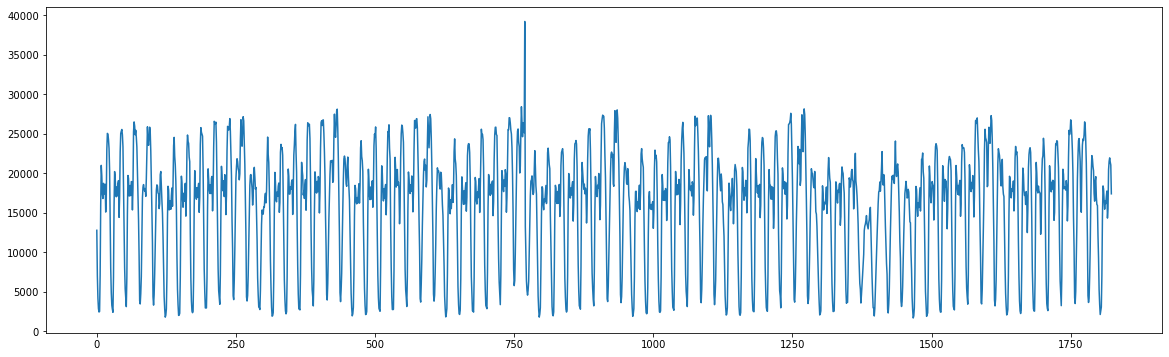

In [51]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']

ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [52]:
#apply fastMERLIN
(discord_indices, 
 discord_NN_indices, 
 discord_dists, 
 discord_times, 
 discord_misses) = fastMERLIN(ts, 
                               5, 96,
                               min_dist=None,
                          MERLIN_initializer=True
                             )


discord_indices_fastMERLIN = discord_indices
discord_NN_indices_fastMERLIN =  discord_NN_indices
discord_dists_fastMERLIN = discord_dists
time_fastMERLIN = discord_times

print('fastMERLIN takes: ', sum(time_fastMERLIN))

L: 5>>>L: 6>>>L: 7>>>L: 8>>>L: 9>>>L: 10>>>L: 11>>>L: 12>>>L: 13>>>L: 14>>>L: 15>>>L: 16>>>L: 17>>>L: 18>>>L: 19>>>L: 20>>>L: 21>>>L: 22>>>L: 23>>>L: 24>>>L: 25>>>L: 26>>>L: 27>>>L: 28>>>L: 29>>>L: 30>>>L: 31>>>L: 32>>>L: 33>>>L: 34>>>L: 35>>>L: 36>>>L: 37>>>L: 38>>>L: 39>>>L: 40>>>L: 41>>>L: 42>>>L: 43>>>L: 44>>>L: 45>>>L: 46>>>L: 47>>>L: 48>>>L: 49>>>L: 50>>>L: 51>>>L: 52>>>L: 53>>>L: 54>>>L: 55>>>L: 56>>>L: 57>>>L: 58>>>L: 59>>>L: 60>>>L: 61>>>L: 62>>>L: 63>>>L: 64>>>L: 65>>>L: 66>>>L: 67>>>L: 68>>>L: 69>>>L: 70>>>L: 71>>>L: 72>>>L: 73>>>L: 74>>>L: 75>>>L: 76>>>L: 77>>>L: 78>>>L: 79>>>L: 80>>>L: 81>>>L: 82>>>L: 83>>>L: 84>>>L: 85>>>L: 86>>>L: 87>>>L: 88>>>L: 89>>>L: 90>>>L: 91>>>L: 92>>>L: 93>>>L: 94>>>L: 95>>>L: 96>>>fastMERLIN takes:  4.695280313491821


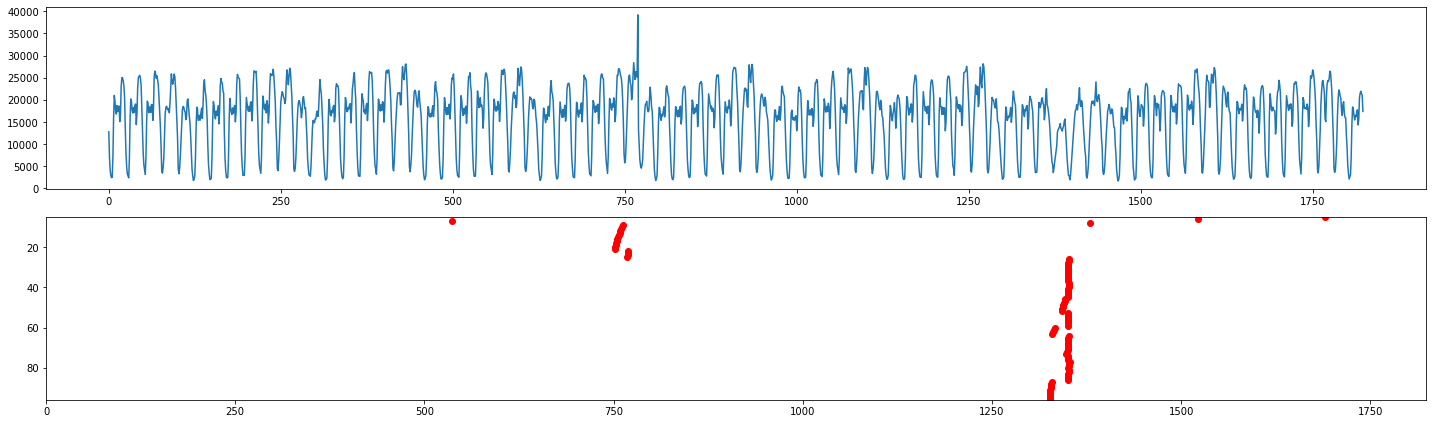

time_fastMERLIN:  4.695280313491821


In [53]:
#plot discords indices and their corresponding length
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for i, L in enumerate(np.arange(5,97)):
    ax[1].scatter(x=discord_indices[i], y=L, c='r')

fig.tight_layout()
plt.show()

print('time_fastMERLIN: ', sum(time_fastMERLIN))

To make sure the results of MERLIN and fastMERLIN are the same, we apply MERLIN below and compare its result 
with what achieved by fastMERLIN

In [33]:
tic = time.time()
Discords = MERLIN(ts, 5, 96, separation_fraction=None) #separation_fraction=None: means stumpy default setting for ignoring trivial checks
toc = time.time()

#computation time:
time_MERLIN = toc - tic

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [1690, 5, 1120, 1.3642079150627304]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [1522, 6, 1100, 1.4064712539239808]
>>> Discords after finding the next four discords:  [537, 7, 1689, 1.62928107746437]
>>> Discords after finding the next four discords:  [1380, 8, 443, 1.746810126819628]
>>> Discords after finding the next four discords:  [762, 9, 1328, 2.0634858945465493]
Stage#3: Calculating the remaining discords...
>>> new discord:  [761, 10, 1327, 2.1247537919540944]
>>> new discord:  [760, 11, 1381, 2.629462897528745]
>>> new discord:  [759, 12, 1380, 2.746225055671875]
>>> new discord:  [758, 13, 1379, 2.9819137944892202]
>>> new discord:  [757, 14, 1261, 3.5977491081910626]
>>> new discord:  [756, 15, 1260, 3.7262163688495025]
>>> new discord:  [755, 16, 1259, 3.8542112273477858]
>>> new discord:  [754, 17, 1258, 3.773480491623614]
>>> new disco

In [34]:
discord_indices_MERLIN = np.array([int(x) for x in Discords[:,0]])
discord_NN_indices_MERLIN =  np.array([int(x) for x in Discords[:,1]])
discord_dists_MERLIN = Discords[:,3]

print('computation time when using MERLIN: ', time_MERLIN) 

computation time when using MERLIN:  304.0689787864685


please note that we are z-normalizing each subseq in each iteration. creating the all_subsequnces matrix and having the z-normalized subsequences ready might reduce the computation time. Therefore, to compare MERLIN and fastMERLIN regarding their computation time, we used the MATLAB code!

## Using Matrix Profile to get discords

In [54]:
ts = ts.astype(np.float64)

#let's use matrix profile
n_discords = 96 - 5 + 1

discord_indices_MP = np.zeros(n_discords, dtype='int')
discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
discord_dists_MP = np.zeros(n_discords)
time_MP = np.zeros(n_discords)

for i, L in enumerate(np.arange(5,97)):
    print(f'L={L}', end='>>>')
    tic = time.time()
    
    mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
    idx = np.argmax(mp[:,0])
    
    discord_indices_MP[i] = idx
    discord_NN_indices_MP[i] = mp[idx,1]
    discord_dists_MP[i] = mp[idx,0]
    
    toc = time.time()
    time_MP[i] = toc - tic

L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>L=11>>>L=12>>>L=13>>>L=14>>>L=15>>>L=16>>>L=17>>>L=18>>>L=19>>>L=20>>>L=21>>>L=22>>>L=23>>>L=24>>>L=25>>>L=26>>>L=27>>>L=28>>>L=29>>>L=30>>>L=31>>>L=32>>>L=33>>>L=34>>>L=35>>>L=36>>>L=37>>>L=38>>>L=39>>>L=40>>>L=41>>>L=42>>>L=43>>>L=44>>>L=45>>>L=46>>>L=47>>>L=48>>>L=49>>>L=50>>>L=51>>>L=52>>>L=53>>>L=54>>>L=55>>>L=56>>>L=57>>>L=58>>>L=59>>>L=60>>>L=61>>>L=62>>>L=63>>>L=64>>>L=65>>>L=66>>>L=67>>>L=68>>>L=69>>>L=70>>>L=71>>>L=72>>>L=73>>>L=74>>>L=75>>>L=76>>>L=77>>>L=78>>>L=79>>>L=80>>>L=81>>>L=82>>>L=83>>>L=84>>>L=85>>>L=86>>>L=87>>>L=88>>>L=89>>>L=90>>>L=91>>>L=92>>>L=93>>>L=94>>>L=95>>>L=96>>>

### NOW, let's compare fastMERLIN vs MP (and vs MERLIN):

Here, we try to substract the arrays that contain the corresponding info for discords of length 5-96 (i.e. length of array: 92)

In [55]:
#To compare indices of discords

print('>>> diff between discord indices discovered by fastMERLIN and MP: \n', discord_indices_fastMERLIN - discord_indices_MP)
print('---------------------------------------------')
print('>>> diff between discord indices discovered by MERLIN and MP: \n', discord_indices_MERLIN - discord_indices_MP)


>>> diff between discord indices discovered by fastMERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---------------------------------------------
>>> diff between discord indices discovered by MERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [56]:
print('fastMERLIN computation time: ', np.sum(time_fastMERLIN))

print('MP computation time: ', np.sum(time_MP))

fastMERLIN computation time:  4.695280313491821
MP computation time:  0.9365420341491699


In [38]:
#to check it with MERLIN MATLAB if there is bug:
MERLIN_bug_idx = np.where(discord_indices_MERLIN - discord_indices_MP > 0)[0]
print('potential bug of MERLIN located at index (of output array): ', MERLIN_bug_idx)
print('indices discovered by Python MERLIN are: ', discord_indices_MERLIN[MERLIN_bug_idx])

potential bug of MERLIN located at index (of output array):  []
indices discovered by Python MERLIN are:  []


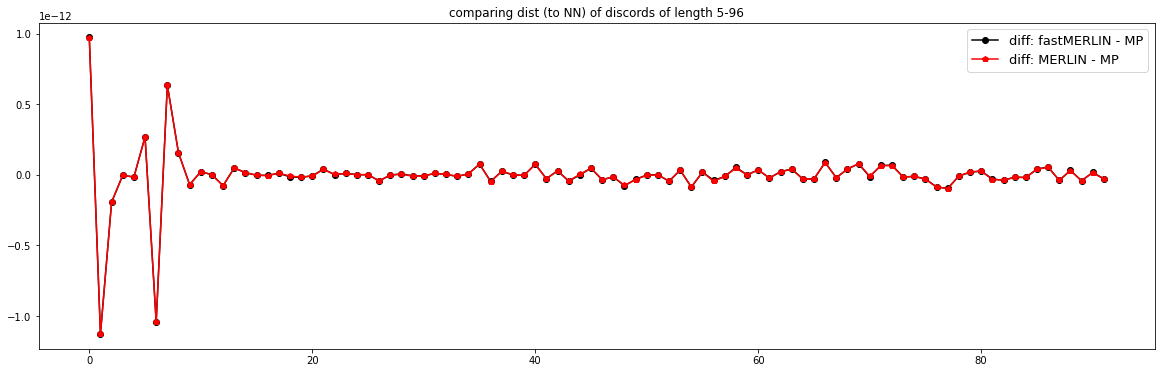

In [39]:
#To compare dist of discords to their NN, we plot the difference between fastMERLIN/MERLIN and MP 
plt.figure()
plt.title('comparing dist (to NN) of discords of length 5-96')

plt.plot(discord_dists_fastMERLIN - discord_dists_MP, c='k', marker='o', label='diff: fastMERLIN - MP')
plt.plot(discord_dists_MERLIN - discord_dists_MP, c='r', marker='p', label='diff: MERLIN - MP')

plt.legend(loc=1, fontsize=13)
plt.show()

In [40]:
#To compare NN indices of discords

print('>>> diff between discord NN indices discovered by fastMERLIN and MP: \n', discord_NN_indices_fastMERLIN - discord_NN_indices_MP)
print('---------------------------------------------')
print('>>> diff between discord NN indices discovered by MERLIN and MP: \n', discord_NN_indices_MERLIN - discord_NN_indices_MP)


>>> diff between discord NN indices discovered by fastMERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---------------------------------------------
>>> diff between discord NN indices discovered by MERLIN and MP: 
 [-1115 -1094 -1682  -435 -1319 -1317 -1370 -1368 -1366 -1247 -1245 -1243
 -1241 -1239 -1574 -1572 -1571   -75   -74   -73   -71 -1375 -1374 -1372
  -220  -219  -218  -217  -216  -215  -214  -213  -212  -212  -210  -209
  -207  -206  -204  -203  -202  -199  -197  -195  -193  -192  -190  -188
  -195  -194  -193  -192  -191  -190  -189  -171  -169  -167  -164  -903
  -901  -900  -899  -898  -897  -895  -894  -892  -890 -1228 -1226 -1226
  -891    70    71    73 -1439 -1438 -1436 -1435 -1433 -1432  -858 -1072
 -1407 -1406 -1404 -1547 -1546  -537 -1543 -1542]


**NOTE:** fastMERLIN preserves the order of subsequences. Therefore, it is possible to have more than 1 NN. However, MERLIN cannot preserve the order of subsequences as they appear in T. Therefore, we might end up with different NN when we use MERLIN.

## Let's compare fastMERLIN and MP for another data set (used in the paper)

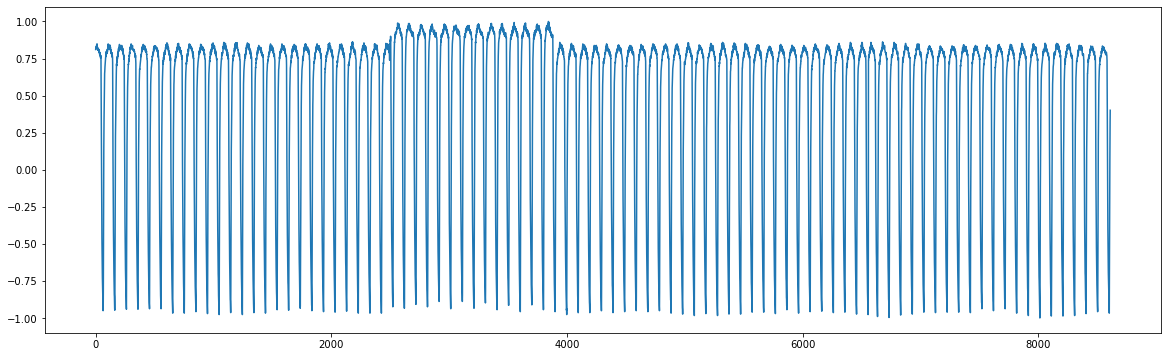

with length:  8612


In [41]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None)
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))
ts = ts.astype(np.float64)

plt.plot(ts)
plt.show()
print('with length: ', len(ts))

In [42]:
#setting  the lower bound and upper bound for the length of discords
minL = 50; maxL = 500;
L_vec =  np.arange(minL,maxL+1)

In [47]:
#use MP:
n_discords = maxL - minL + 1

discord_indices_MP = np.zeros(n_discords, dtype='int')
discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
discord_dists_MP = np.zeros(n_discords)
time_MP = np.zeros(n_discords)

for i, L in enumerate(np.arange(minL,maxL+1)):
    print(f'L={L}', end='>>>')
    tic = time.time()
    
    mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
    idx = np.argmax(mp[:,0])
    
    discord_indices_MP[i] = idx
    discord_NN_indices_MP[i] = mp[idx,1]
    discord_dists_MP[i] = mp[idx,0]
    
    toc = time.time()
    time_MP[i] = toc - tic

L=50>>>L=51>>>L=52>>>L=53>>>L=54>>>L=55>>>L=56>>>L=57>>>L=58>>>L=59>>>L=60>>>L=61>>>L=62>>>L=63>>>L=64>>>L=65>>>L=66>>>L=67>>>L=68>>>L=69>>>L=70>>>L=71>>>L=72>>>L=73>>>L=74>>>L=75>>>L=76>>>L=77>>>L=78>>>L=79>>>L=80>>>L=81>>>L=82>>>L=83>>>L=84>>>L=85>>>L=86>>>L=87>>>L=88>>>L=89>>>L=90>>>L=91>>>L=92>>>L=93>>>L=94>>>L=95>>>L=96>>>L=97>>>L=98>>>L=99>>>L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>L=111>>>L=112>>>L=113>>>L=114>>>L=115>>>L=116>>>L=117>>>L=118>>>L=119>>>L=120>>>L=121>>>L=122>>>L=123>>>L=124>>>L=125>>>L=126>>>L=127>>>L=128>>>L=129>>>L=130>>>L=131>>>L=132>>>L=133>>>L=134>>>L=135>>>L=136>>>L=137>>>L=138>>>L=139>>>L=140>>>L=141>>>L=142>>>L=143>>>L=144>>>L=145>>>L=146>>>L=147>>>L=148>>>L=149>>>L=150>>>L=151>>>L=152>>>L=153>>>L=154>>>L=155>>>L=156>>>L=157>>>L=158>>>L=159>>>L=160>>>L=161>>>L=162>>>L=163>>>L=164>>>L=165>>>L=166>>>L=167>>>L=168>>>L=169>>>L=170>>>L=171>>>L=172>>>L=173>>>L=174>>>L=175>>>L=176>>>L=177>>>L=178>>>L=179>>>L=180>>>L=

In [48]:
#use fastMERLIN:
(discord_indices, 
 discord_NN_indices, 
 discord_dists, 
 discord_times, 
 discord_misses) = fastMERLIN(ts, 
                               minL, maxL,
                               min_dist=None,
                              MERLIN_initializer = True
                             )


discord_indices_fastMERLIN = discord_indices
discord_NN_indices_fastMERLIN =  discord_NN_indices
discord_dists_fastMERLIN = discord_dists
time_fastMERLIN = discord_times

print('fastMERLIN takes: ', sum(time_fastMERLIN))

L: 50>>>L: 51>>>L: 52>>>L: 53>>>L: 54>>>L: 55>>>L: 56>>>L: 57>>>L: 58>>>L: 59>>>L: 60>>>L: 61>>>L: 62>>>L: 63>>>L: 64>>>L: 65>>>L: 66>>>L: 67>>>L: 68>>>L: 69>>>L: 70>>>L: 71>>>L: 72>>>L: 73>>>L: 74>>>L: 75>>>L: 76>>>L: 77>>>L: 78>>>L: 79>>>L: 80>>>L: 81>>>L: 82>>>L: 83>>>L: 84>>>L: 85>>>L: 86>>>L: 87>>>L: 88>>>L: 89>>>L: 90>>>L: 91>>>L: 92>>>L: 93>>>L: 94>>>L: 95>>>L: 96>>>L: 97>>>L: 98>>>L: 99>>>L: 100>>>L: 101>>>L: 102>>>L: 103>>>L: 104>>>L: 105>>>L: 106>>>L: 107>>>L: 108>>>L: 109>>>L: 110>>>L: 111>>>L: 112>>>L: 113>>>L: 114>>>L: 115>>>L: 116>>>L: 117>>>L: 118>>>L: 119>>>L: 120>>>L: 121>>>L: 122>>>L: 123>>>L: 124>>>L: 125>>>L: 126>>>L: 127>>>L: 128>>>L: 129>>>L: 130>>>L: 131>>>L: 132>>>L: 133>>>L: 134>>>L: 135>>>L: 136>>>L: 137>>>L: 138>>>L: 139>>>L: 140>>>L: 141>>>L: 142>>>L: 143>>>L: 144>>>L: 145>>>L: 146>>>L: 147>>>L: 148>>>L: 149>>>L: 150>>>L: 151>>>L: 152>>>L: 153>>>L: 154>>>L: 155>>>L: 156>>>L: 157>>>L: 158>>>L: 159>>>L: 160>>>L: 161>>>L: 162>>>L: 163>>>L: 164>>>L: 165>>>L: 166

total diff in indices of discords: 
 0
-------------------------
total diff in NN indices of discords: 
 0
-------------------------
diff in indices of dist-to-NN: see the figure below!


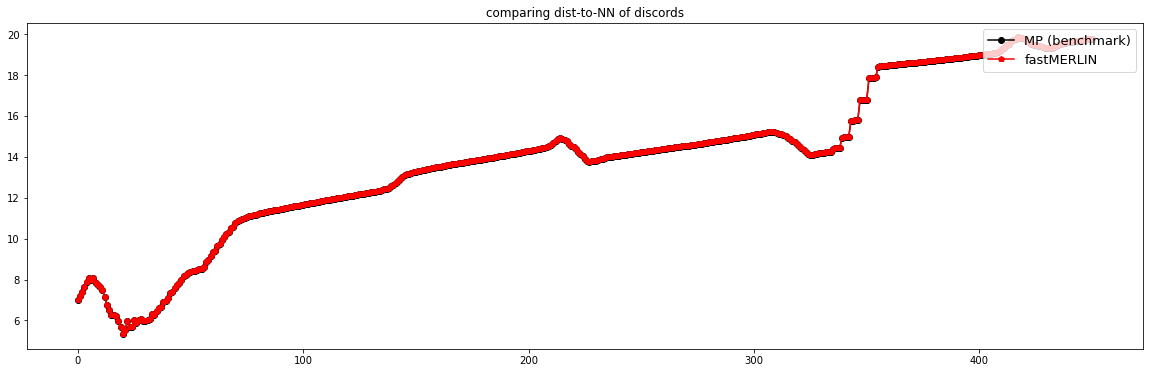

-------------------------
fastMERLIN computation time:  113.28792667388916
MP computation time:  51.38243389129639


In [49]:
print('total diff in indices of discords: \n', np.sum(abs(discord_indices_fastMERLIN - discord_indices_MP)) )
print('-------------------------')
print('total diff in NN indices of discords: \n', np.sum(abs(discord_NN_indices_fastMERLIN - discord_NN_indices_MP)) )
print('-------------------------')

print('diff in indices of dist-to-NN: see the figure below!')
plt.figure()
plt.title('comparing dist-to-NN of discords')

plt.plot(discord_dists_MP, c='k', marker='o', label='MP (benchmark)')
plt.plot(discord_dists_fastMERLIN, c='r', marker='p', label='fastMERLIN')

plt.legend(loc=1, fontsize=13)
plt.show()
      
print('-------------------------')
print('fastMERLIN computation time: ', np.sum(time_fastMERLIN))
print('MP computation time: ', np.sum(time_MP))

In [50]:
#to debug fastMERLIN:
bugs_loc = np.where(discord_indices_fastMERLIN - discord_indices_MP != 0)[0]

bugs_dict = {}

bugs_dict['loc'] =  bugs_loc
bugs_dict['length'] = L_vec[bugs_loc]

bugs_dict['indices by fastMERLIN'] = discord_indices_fastMERLIN[bugs_loc]
bugs_dict['NN indices by fastMERLIN'] = discord_NN_indices_fastMERLIN[bugs_loc]
bugs_dict['dist by fastMERLIN'] = discord_dists_fastMERLIN[bugs_loc]

bugs_dict['indices by MP'] = discord_indices_MP[bugs_loc]
bugs_dict['NN indices by MP'] = discord_NN_indices_MP[bugs_loc]
bugs_dict['dist by MP'] = discord_dists_MP[bugs_loc]

df = pd.DataFrame(bugs_dict)
df #if empty, that means there is no problem

,loc,length,indices by fastMERLIN,NN indices by fastMERLIN,dist by fastMERLIN,indices by MP,NN indices by MP,dist by MP


## Compare fastMERLIN and STUMPY on different cases

In [58]:
def discord_finder_MP(T, minL, maxL):
    n_discords = maxL - minL + 1
    
    discord_indices_MP = np.zeros(n_discords, dtype='int')
    discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
    discord_dists_MP = np.zeros(n_discords)
    time_MP = np.zeros(n_discords)

    for i, L in enumerate(np.arange(minL,maxL+1)):
        print(f'L={L}', end='>>>')
        tic = time.time()

        mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
        idx = np.argmax(mp[:,0])

        discord_indices_MP[i] = idx
        discord_NN_indices_MP[i] = mp[idx,1]
        discord_dists_MP[i] = mp[idx,0]

        toc = time.time()
        time_MP[i] = toc - tic
    
    return discord_indices_MP, discord_NN_indices_MP, discord_dists_MP, time_MP

In below, we read data and we create a longer version of by expanding the time series from left(right) of anomaly segement.

In [59]:
expand_factor = 100 #will be used to expand the time series

### since data

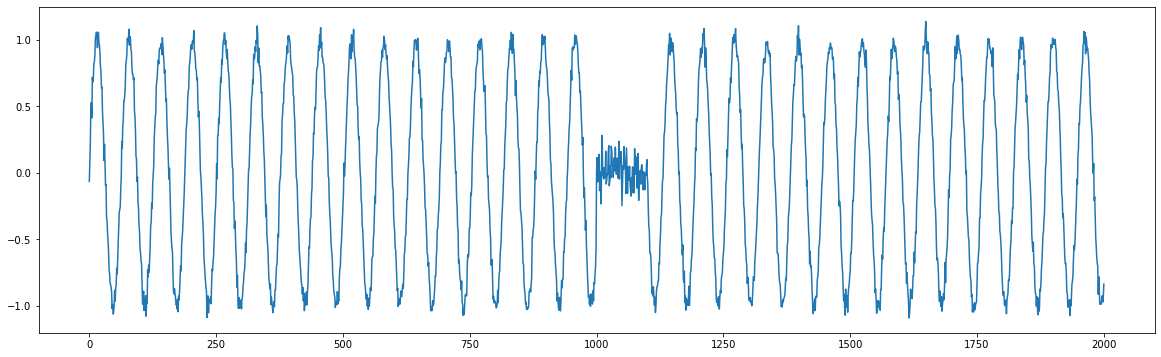

In [60]:
#sine data (short)
data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts_sine = data['T'].reshape(-1,)
ts_sine = ts_sine.astype(np.float64)

plt.plot(ts_sine)
plt.show()

In [61]:
#sine data (long): expanding from left and right
tmp_left = np.tile(ts_sine[:750], expand_factor)
tmp_middle = np.tile(ts_sine[750:1250], 1)
tmp_right = np.tile(ts_sine[1250:], expand_factor)

ts_sine_long = np.r_[tmp_left, tmp_middle, tmp_right]
print('lenght of ts_sine_long: ', len(ts_sine_long))

lenght of ts_sine_long:  150600


### taxi data

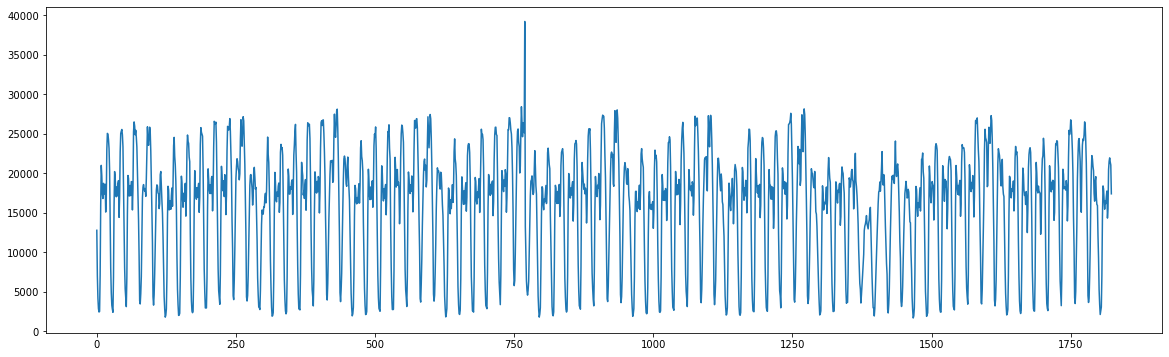

In [62]:
#taxi data 
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']

ts_taxi = np.reshape(data.to_numpy(),newshape=(-1,))

#let's consider only the data at each hour (not the half hours)
ts_taxi = [val for i,val in enumerate(ts_taxi) if i % 2 == 0]
ts_taxi = np.asarray(ts_taxi, dtype='float64')

plt.plot(ts_taxi)
plt.show()

In [63]:
#taxi data (long)

tmp_left = np.tile(ts_taxi[:500], expand_factor)
tmp_middle = np.tile(ts_taxi[500:1000], 1)
tmp_right = np.tile(ts_taxi[1000:], expand_factor)

ts_taxi_long = np.r_[tmp_left, tmp_middle, tmp_right]
print('lenght of ts_taxi_long: ', len(ts_taxi_long))

lenght of ts_taxi_long:  132900


### Sinence Lab Data

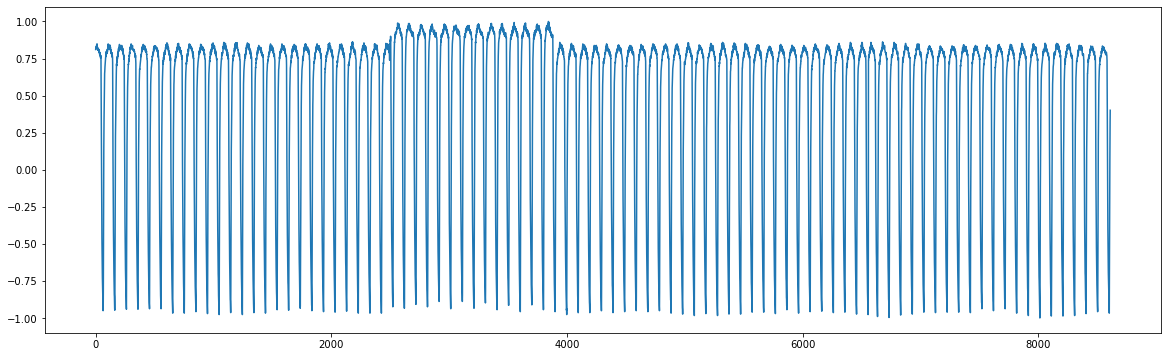

In [64]:
#science lab data
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None)
ts_lab = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))
ts_lab = ts_lab.astype(np.float64)

plt.plot(ts_lab)
plt.show()

In [66]:
#lab data (long)

tmp_left = np.tile(ts_lab[:2000], expand_factor//3)
tmp_middle = np.tile(ts_lab[2000:4000], 1)
tmp_right = np.tile(ts_lab[4000:], expand_factor//3)

ts_lab_long = np.r_[tmp_left, tmp_middle, tmp_right]
print('lenght of ts_lab_long: ', len(ts_lab_long))

lenght of ts_lab_long:  220196


In [67]:
ts_names_list = ['ts_sine', 'ts_taxi', 'ts_lab']

ts_short = {'ts_sine': ts_sine, 
            'ts_taxi': ts_taxi,
            'ts_lab': ts_lab
           }

ts_long = {'ts_sine': ts_sine_long, 
            'ts_taxi': ts_taxi_long,
            'ts_lab': ts_lab_long
           }

discord_length_choices = {'ts_sine': (500,510), 
               'ts_taxi':(5, 10),
               'ts_lab':(100, 110)}

## part-1: compare fastMERLIN and MP on short time series

ts:  ts_sine

> stumpy: 
L=500>>>L=501>>>L=502>>>L=503>>>L=504>>>L=505>>>L=506>>>L=507>>>L=508>>>L=509>>>L=510>>>
> fastMERLN: 
L: 500>>>L: 501>>>L: 502>>>L: 503>>>L: 504>>>L: 505>>>L: 506>>>L: 507>>>L: 508>>>L: 509>>>L: 510>>>

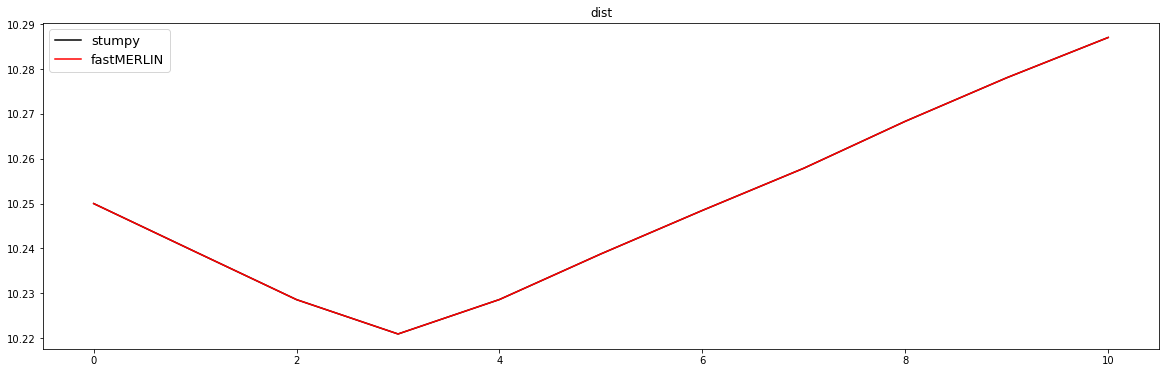

ts:  ts_taxi

> stumpy: 
L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>
> fastMERLN: 
L: 5>>>L: 6>>>L: 7>>>L: 8>>>L: 9>>>L: 10>>>

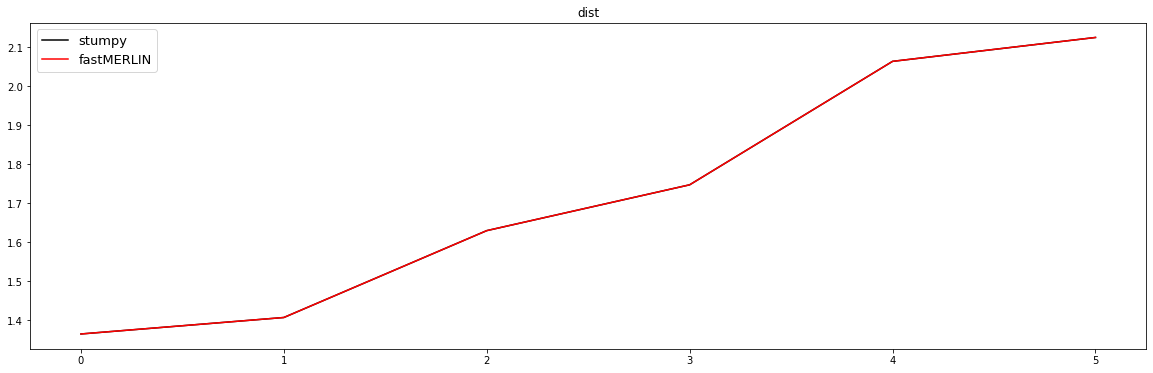

ts:  ts_lab

> stumpy: 
L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>
> fastMERLN: 
L: 100>>>L: 101>>>L: 102>>>L: 103>>>L: 104>>>L: 105>>>L: 106>>>L: 107>>>L: 108>>>L: 109>>>L: 110>>>

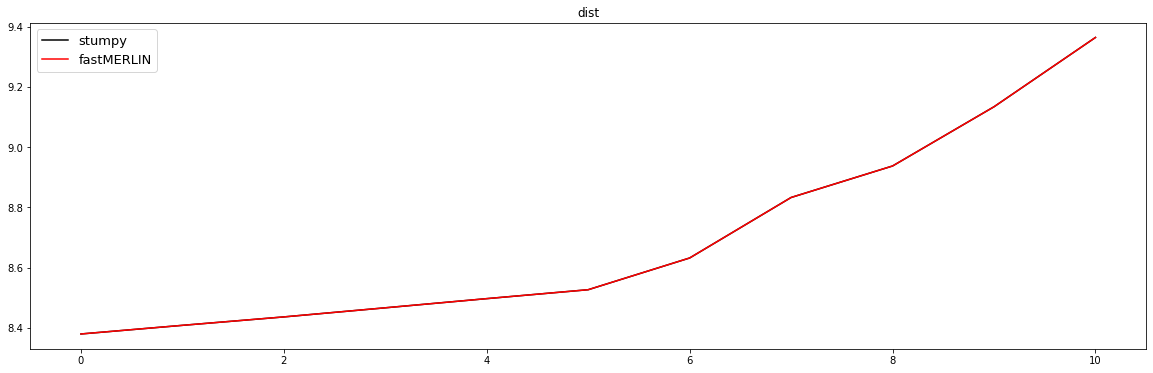

In [68]:
computation_time_dict = {}

for ts_name in ts_names_list:
    print('===================================')
    print('ts: ', ts_name)
    
    computation_time_list = []
    
    ts = ts_short[ts_name]
    minL, maxL = discord_length_choices[ts_name]
    
    #stumpy:
    print('\n> stumpy: ')
    discord_indices_MP, discord_NN_indices_MP, discord_dists_MP, time_MP = discord_finder_MP(ts, minL, maxL)
    computation_time_list.append(np.sum(time_MP))
    
    
    #fastMERLIN:
    print('\n> fastMERLN: ')
    discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses = fastMERLIN(ts, minL, maxL)
    computation_time_list.append(np.sum(discord_times))
    
    if np.sum(np.abs(discord_indices - discord_indices_MP)) != 0:
        raise ValueError("different discord indices")
        
    plt.figure()
    plt.title('dist')
    plt.plot(discord_dists_MP, c='k', label='stumpy')
    plt.plot(discord_dists, c='r', label='fastMERLIN')
    plt.legend(fontsize=13)
    plt.show()
    
    if len(np.where(np.abs(discord_dists - discord_dists_MP) > 1e-6)[0]) > 0 :
        raise ValueError("different discord dists using fastMERLIN and STUMPY")
    
    if np.sum(np.abs(discord_NN_indices - discord_NN_indices_MP)) != 0:
        raise ValueError("different discord indices")
    
    computation_time_dict[ts_name] = computation_time_list

In [69]:
#comparing perfomance of stumpy (first column) and fastMERLIN (second column) 
#...on short time series

df = pd.DataFrame(computation_time_dict)
df.index = ['stumpy', 'fastMERLIN'] 
df

,ts_sine,ts_taxi,ts_lab
stumpy,0.123667,0.064826,1.100907
fastMERLIN,1.040503,0.300369,2.690129


## part-2: compare fastMERLIN and MP on long time series 

ts:  ts_sine

> stumpy: 
L=500>>>L=501>>>L=502>>>L=503>>>L=504>>>L=505>>>L=506>>>L=507>>>L=508>>>L=509>>>L=510>>>
> fastMERLN: 
L: 500>>>L: 501>>>L: 502>>>L: 503>>>L: 504>>>L: 505>>>L: 506>>>L: 507>>>L: 508>>>L: 509>>>L: 510>>>

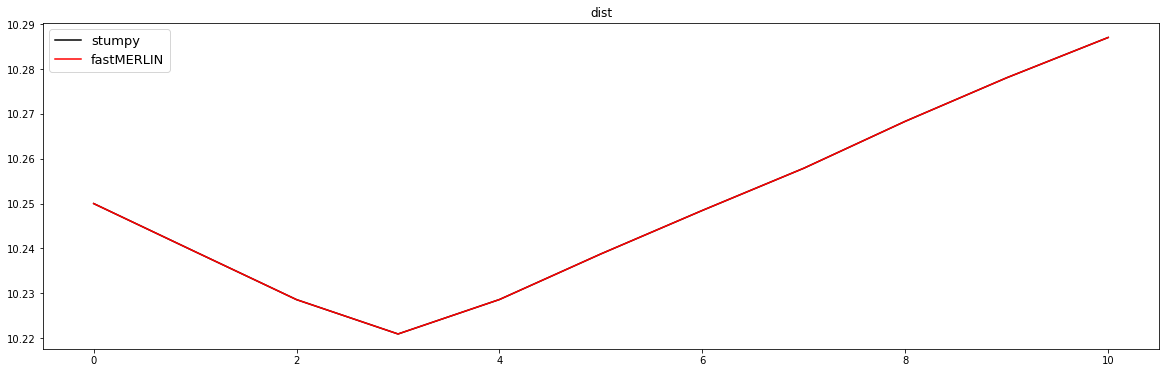

ts:  ts_taxi

> stumpy: 
L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>
> fastMERLN: 
L: 5>>>L: 6>>>L: 7>>>L: 8>>>L: 9>>>L: 10>>>

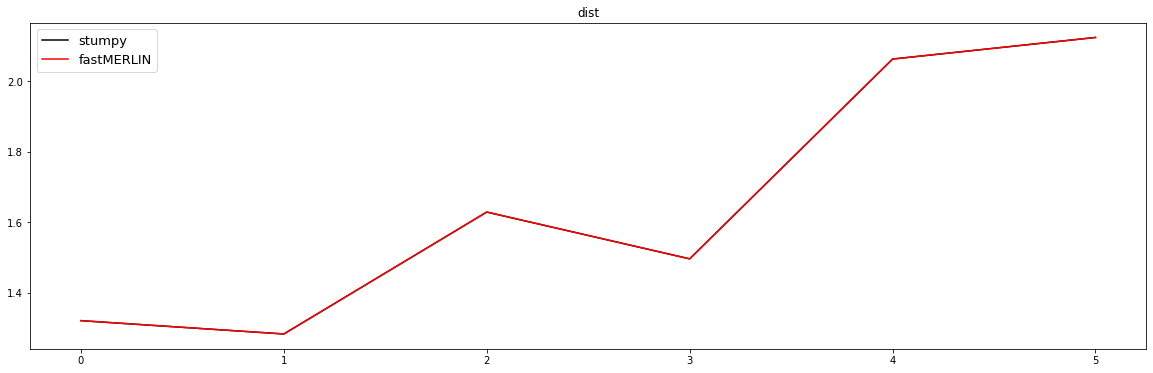

ts:  ts_lab

> stumpy: 
L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>
> fastMERLN: 
L: 100>>>L: 101>>>L: 102>>>L: 103>>>L: 104>>>L: 105>>>L: 106>>>L: 107>>>L: 108>>>L: 109>>>L: 110>>>

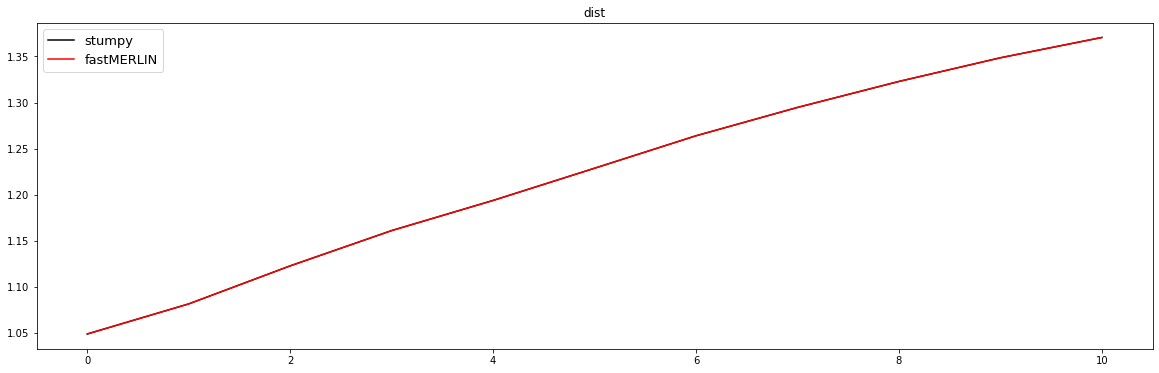

In [70]:
computation_time_dict = {}
ts_length = {}

for ts_name in ts_names_list:
    print('===================================')
    print('ts: ', ts_name)
    computation_time_list = [] #to store computation time of stumpy and fastMERLIN

    ts = ts_long[ts_name]
    ts_length[ts_name] = len(ts)
    
    minL, maxL = discord_length_choices[ts_name]
    
    #stumpy:
    print('\n> stumpy: ')
    discord_indices_MP, discord_NN_indices_MP, discord_dists_MP, time_MP = discord_finder_MP(ts, minL, maxL)
    computation_time_list.append(np.sum(time_MP))
    
    
    #fastMERLIN:
    print('\n> fastMERLN: ')
    discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses = fastMERLIN(ts, minL, maxL)
    computation_time_list.append(np.sum(discord_times))
    
    if np.sum(np.abs(discord_indices - discord_indices_MP)) != 0:
        raise ValueError("different discord indices")
        
    plt.figure()
    plt.title('dist')
    plt.plot(discord_dists_MP, c='k', label='stumpy')
    plt.plot(discord_dists, c='r', label='fastMERLIN')
    plt.legend(fontsize=13)
    plt.show()
    
    if len(np.where(np.abs(discord_dists - discord_dists_MP) > 1e-6)[0]) > 0 :
        raise ValueError("different discord dists using fastMERLIN and STUMPY")
    
    computation_time_dict[ts_name] = computation_time_list

In [71]:
#comparing perfomance of stumpy (first column) and fastMERLIN (second column) 
#... on long time series
df = pd.DataFrame(computation_time_dict)
df.index = ['stumpy', 'fastMERLIN']
df

,ts_sine,ts_taxi,ts_lab
stumpy,661.767806,283.407854,1660.813976
fastMERLIN,83.131808,20.539943,93.508553
